In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import set_config

pd.set_option("display.max_columns", 85)
sns.set_theme(context="paper", font_scale=1.5, style="ticks")
set_config(display="diagram")

# Random Forest: Scoring 

- ci sono alcuni fenotipi migliori, scarsi?

### Load data

In [2]:
# Read Features Data (NEW from PP)
df = pd.read_csv("./data/features_and_response.noscale.csv", index_col=0)

# Drop NaNs
df.dropna(inplace=True)

# Collect Features and Labels
features_df = pd.DataFrame()
conf = df.drop(labels=["response", "occ_total_sum", "oldest_phylostratum"], axis=1)
features_df["occ_total_sum"] = df["occ_total_sum"]
features_df["oldest_phylostratum"] = df["oldest_phylostratum"]
features_df = pd.concat([features_df, conf], axis=1)

X = features_df.to_numpy()

# Old and New response both in this DF
# response = pd.read_csv("./data/old_and_new_response.csv", index_col=0)

# Read phenotype data
pheno_old_df = pd.read_csv("./data/2019_pheno.csv", index_col=0)
pheno_df = pd.read_csv("./data/2022_pheno.csv", index_col=0)

### Custom Scoring: Area Under Precision Recall Curve

In [287]:
from sklearn.metrics import auc, make_scorer, precision_recall_curve

def auprc(y_true, y_scores, **kwargs):
    """ Remember to use make_scorer(auprc, needs_proba=True,) when feeding to SKL."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores) 
    return auc(x=recalls, y=precisions)

*** 
## Regular CV

In [288]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

rf_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", BalancedRandomForestClassifier(
        n_jobs=-1, 
        min_samples_leaf=10, 
        min_samples_split=10,
        n_estimators=1000,
    ),
    ),
])

rf_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 BalancedRandomForestClassifier(min_samples_leaf=10,
                                                min_samples_split=10,
                                                n_estimators=1000,
                                                n_jobs=-1))])

In [5]:
pheno_df

,HP:0000002,HP:0000003,HP:0000008,HP:0000009,HP:0000010,HP:0000014,HP:0000020,HP:0000023,HP:0000025,HP:0000027,HP:0000028,HP:0000032,HP:0000035,HP:0000036,HP:0000044,HP:0000045,HP:0000046,HP:0000047,HP:0000050,HP:0000054,HP:0000055,HP:0000062,HP:0000069,HP:0000076,HP:0000077,HP:0000078,HP:0000079,HP:0000080,HP:0000083,HP:0000085,HP:0000089,HP:0000091,HP:0000093,HP:0000095,HP:0000098,HP:0000100,HP:0000104,HP:0000107,HP:0000112,HP:0000119,HP:0000123,HP:0000124,...,HP:0100660,HP:0100689,HP:0100691,HP:0100692,HP:0100699,HP:0100704,HP:0100705,HP:0100710,HP:0100716,HP:0100729,HP:0100736,HP:0100737,HP:0100738,HP:0100749,HP:0100755,HP:0100763,HP:0100790,HP:0100806,HP:0100807,HP:0100840,HP:0100851,HP:0100852,HP:0100871,HP:0100872,HP:0100886,HP:0100887,HP:0200006,HP:0200007,HP:0200021,HP:0200036,HP:0200042,HP:0200055,HP:0200134,HP:0410008,HP:0410030,HP:0410042,HP:0410043,HP:0410263,HP:0410280,HP:0500015,HP:3000050,HP:4000059
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1000,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
9990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9991,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [6]:
from sklearn.model_selection import cross_validate

np.random.seed(42)
k = 5
roc_mean = []
roc_std = []
prc_mean = []
prc_std = []

for i, pheno in enumerate(pheno_df.columns):
    
    y = pheno_df[pheno]
    
    cv = cross_validate( 
        estimator=rf_clf,
        X=X, y=y, 
        cv=k,# Defaults to stratified K fold
        scoring={"auroc":"roc_auc", "auprc": make_scorer(auprc, needs_proba=True)}
    )
    
    roc_mean.append(cv["test_auroc"].mean())
    roc_std.append(cv["test_auroc"].std())
    prc_mean.append(cv["test_auprc"].mean())
    prc_std.append(cv["test_auprc"].std())
    
    if (i%100 == 0): 
        print("Finished", i+1, "phenotypes out of 1361")
        print(cv["test_auroc"].mean())
        print()
        
    i+=1

Finished 1 phenotypes out of 1361
0.6998350583480022

Finished 101 phenotypes out of 1361
0.7113700175197347

Finished 201 phenotypes out of 1361
0.7735203820569674

Finished 301 phenotypes out of 1361
0.6503248753507749

Finished 401 phenotypes out of 1361
0.6939665431232918

Finished 501 phenotypes out of 1361
0.6967224279921841

Finished 601 phenotypes out of 1361
0.6876154201292706

Finished 701 phenotypes out of 1361
0.7188676889725982

Finished 801 phenotypes out of 1361
0.6737067877761485

Finished 901 phenotypes out of 1361
0.6340994784070061

Finished 1001 phenotypes out of 1361
0.6200784256574572

Finished 1101 phenotypes out of 1361
0.6336590914576978

Finished 1201 phenotypes out of 1361
0.7103835852962683

Finished 1301 phenotypes out of 1361
0.7090780439019184



In [4]:
cv_df = pd.DataFrame(
    zip(roc_mean, roc_std, prc_mean, prc_std), 
    columns = ["mean_auroc", "std_auroc", "mean_auprc", "std_auprc"],
    index=pheno_df.columns
)
cv_df

NameError: name 'roc_mean' is not defined

In [5]:
cv_df = pd.read_csv("./results/single_phenotype_cv_scores.csv", index_col=0)
cv_df.head()

,mean_auroc,std_auroc,mean_auprc,std_auprc,HPO ID,HPO Name,# Positive Labels,% Positive Labels,Distance from HP:0000118
HP:0000002,0.699835,0.031420,0.161048,0.019635,HP:0000002,Abnormality of body height,1413,7.776555,2.0
HP:0000003,0.627032,0.035225,0.011078,0.002610,HP:0000003,Multicystic kidney dysplasia,113,0.621904,7.0
HP:0000008,0.642107,0.041322,0.036983,0.006602,HP:0000008,Abnormal morphology of female internal genitalia,400,2.201431,5.0
HP:0000009,0.688800,0.024942,0.050255,0.009343,HP:0000009,Functional abnormality of the bladder,422,2.322510,5.0
HP:0000010,0.598965,0.051693,0.017696,0.014473,HP:0000010,Recurrent urinary tract infections,139,0.764997,4.0


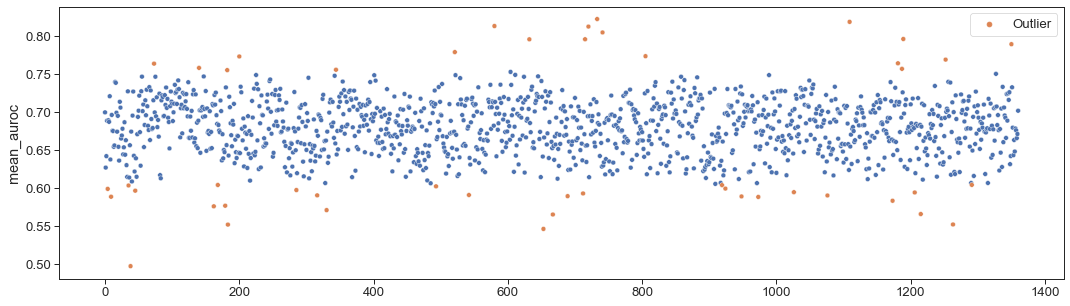

In [6]:
def outliers(row, n_sigma=2):
    
    m = cv_df["mean_auroc"].mean()
    s = cv_df["mean_auroc"].std() * n_sigma
    
    if row["mean_auroc"] >= m + s or row["mean_auroc"] <= m - s:
        return "Outlier"
    else:
        return ""

plt.figure(figsize=(18,5))
ax = sns.scatterplot(
    data=cv_df, x=range(cv_df.shape[0]), y="mean_auroc", 
    hue=cv_df.apply(lambda row: outliers(row), axis=1),
)
plt.show()

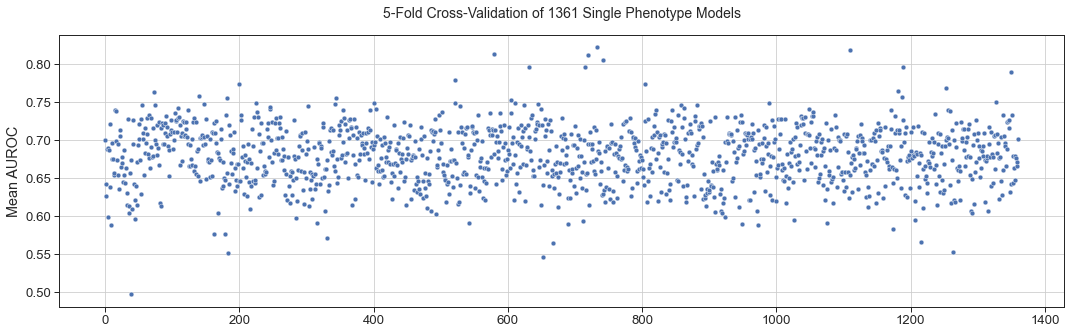

In [7]:
plt.figure(figsize=(18,5))
N = len(cv_df.index)
sns.scatterplot(data=cv_df, x=range(N), y="mean_auroc", )

plt.ylabel("Mean AUROC")
plt.title(f"5-Fold Cross-Validation of {N} Single Phenotype Models", y=1.04, fontsize=14, )
# plt.axhline(y=cv_df["mean_auroc"].mean(), ls="--", lw=2, c=sns.color_palette("colorblind")[3], label="Mean of Means")
# plt.legend()
plt.grid()
plt.show()

In [8]:
cv_df["mean_auroc"].describe()

count    1361.000000
mean        0.680202
std         0.037571
min         0.497115
25%         0.655170
50%         0.681876
75%         0.707407
max         0.822832
Name: mean_auroc, dtype: float64

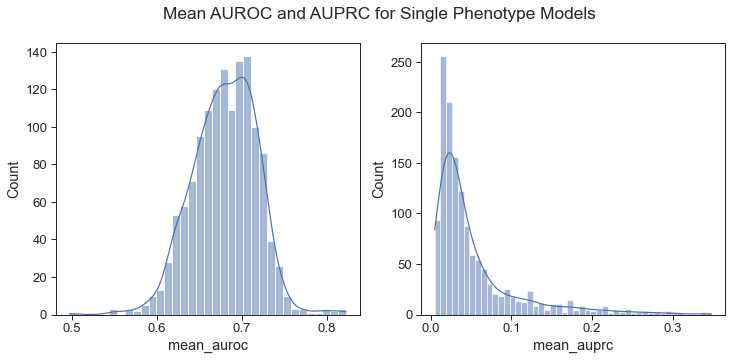

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
sns.histplot(cv_df["mean_auroc"], kde=True, ax=ax[0])
sns.histplot(cv_df["mean_auprc"], kde=True, ax=ax[1])
plt.suptitle("Mean AUROC and AUPRC for Single Phenotype Models")
plt.savefig("figures/single_phenotype_histograms.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
cv_df["mean_auprc"].describe()

count    1361.000000
mean        0.051452
std         0.053277
min         0.004928
25%         0.018819
50%         0.031864
75%         0.059176
max         0.347937
Name: mean_auprc, dtype: float64

In [11]:
import networkx as nx

OBO = nx.gpickle.read_gpickle("data/hp.220616.obo.gpickle")

cv_df["HPO ID"] = cv_df.index
cv_df["HPO Name"] = cv_df["HPO ID"].apply(lambda x: OBO.nodes()[x]["name"])

cv_df["# Positive Labels"] = cv_df["HPO ID"].apply(lambda x: pheno_df[x].sum())
cv_df["% Positive Labels"] = 100 * cv_df["# Positive Labels"] / pheno_df.shape[0]

cv_df

,mean_auroc,std_auroc,mean_auprc,std_auprc,HPO ID,HPO Name,# Positive Labels,% Positive Labels,Distance from HP:0000118
HP:0000002,0.699835,0.031420,0.161048,0.019635,HP:0000002,Abnormality of body height,1413,7.776555,2.0
HP:0000003,0.627032,0.035225,0.011078,0.002610,HP:0000003,Multicystic kidney dysplasia,113,0.621904,7.0
HP:0000008,0.642107,0.041322,0.036983,0.006602,HP:0000008,Abnormal morphology of female internal genitalia,400,2.201431,5.0
HP:0000009,0.688800,0.024942,0.050255,0.009343,HP:0000009,Functional abnormality of the bladder,422,2.322510,5.0
HP:0000010,0.598965,0.051693,0.017696,0.014473,HP:0000010,Recurrent urinary tract infections,139,0.764997,4.0
...,...,...,...,...,...,...,...,...,...
HP:0410263,0.678605,0.032383,0.012260,0.001345,HP:0410263,Brain imaging abnormality,107,0.588883,3.0
HP:0410280,0.676159,0.037642,0.107959,0.024117,HP:0410280,Pediatric onset,941,5.178866,NaN
HP:0500015,0.665838,0.076018,0.023272,0.011732,HP:0500015,Abnormal cardiac test,117,0.643919,2.0
HP:3000050,0.671334,0.043200,0.022314,0.005682,HP:3000050,Abnormal odontoid tissue morphology,210,1.155751,3.0


In [12]:
def path_length(x):
    try:
        L = nx.shortest_path_length(OBO, x, 'HP:0000118', )
        return L
    except:
        return None
    
cv_df["Distance from HP:0000118"] = cv_df["HPO ID"].apply(path_length)

In [13]:
cv_df

,mean_auroc,std_auroc,mean_auprc,std_auprc,HPO ID,HPO Name,# Positive Labels,% Positive Labels,Distance from HP:0000118
HP:0000002,0.699835,0.031420,0.161048,0.019635,HP:0000002,Abnormality of body height,1413,7.776555,2.0
HP:0000003,0.627032,0.035225,0.011078,0.002610,HP:0000003,Multicystic kidney dysplasia,113,0.621904,7.0
HP:0000008,0.642107,0.041322,0.036983,0.006602,HP:0000008,Abnormal morphology of female internal genitalia,400,2.201431,5.0
HP:0000009,0.688800,0.024942,0.050255,0.009343,HP:0000009,Functional abnormality of the bladder,422,2.322510,5.0
HP:0000010,0.598965,0.051693,0.017696,0.014473,HP:0000010,Recurrent urinary tract infections,139,0.764997,4.0
...,...,...,...,...,...,...,...,...,...
HP:0410263,0.678605,0.032383,0.012260,0.001345,HP:0410263,Brain imaging abnormality,107,0.588883,3.0
HP:0410280,0.676159,0.037642,0.107959,0.024117,HP:0410280,Pediatric onset,941,5.178866,NaN
HP:0500015,0.665838,0.076018,0.023272,0.011732,HP:0500015,Abnormal cardiac test,117,0.643919,2.0
HP:3000050,0.671334,0.043200,0.022314,0.005682,HP:3000050,Abnormal odontoid tissue morphology,210,1.155751,3.0


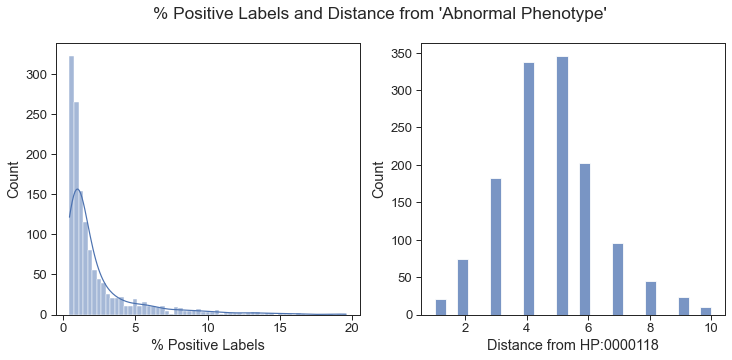

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
sns.histplot(cv_df["% Positive Labels"], kde=True, ax=ax[0])
sns.histplot(cv_df["Distance from HP:0000118"], ax=ax[1])
plt.suptitle("% Positive Labels and Distance from 'Abnormal Phenotype'")
plt.savefig("figures/single_phenotype_histograms_other.png", dpi=300, bbox_inches="tight")
plt.show()

In [15]:
cv_df["Distance from HP:0000118"].describe()

count    1338.000000
mean        4.746637
std         1.639798
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        10.000000
Name: Distance from HP:0000118, dtype: float64

In [16]:
cv_df["% Positive Labels"].describe()

count    1361.000000
mean        2.320330
std         2.748337
min         0.434783
25%         0.764997
50%         1.221794
75%         2.520638
max        19.592735
Name: % Positive Labels, dtype: float64

In [17]:
cv_df.to_csv("./results/single_phenotype_cv_scores.csv")

In [18]:
cv_df.sort_values(by="mean_auroc", ascending=False)[
    ["HPO Name", "mean_auroc", "std_auroc", 
     "% Positive Labels", "Distance from HP:0000118"]
][:10]

,HPO Name,mean_auroc,std_auroc,% Positive Labels,Distance from HP:0000118
HP:0003287,Abnormality of mitochondrial metabolism,0.822832,0.042613,0.776004,4.0
HP:0012103,Abnormality of the mitochondrion,0.819140,0.050835,0.913594,3.0
HP:0002151,Increased serum lactate,0.813627,0.046313,0.946615,5.0
HP:0003128,Lactic acidosis,0.812930,0.029377,0.897083,5.0
HP:0003355,Aminoaciduria,0.805184,0.018904,0.621904,4.0
HP:0030085,Abnormal CSF lactate concentration,0.796535,0.083672,0.462300,3.0
HP:0003112,Abnormal circulating amino acid concentration,0.796205,0.044238,0.687947,4.0
HP:0002490,Increased CSF lactate,0.796138,0.085295,0.462300,4.0
HP:0200055,Small hand,0.789712,0.021787,0.539351,5.0
HP:0001941,Acidosis,0.779274,0.021043,1.887727,4.0


In [19]:
cv_df.sort_values(by="mean_auroc", ascending=True)[
    ["HPO Name", "mean_auroc", "std_auroc", 
     "% Positive Labels", "Distance from HP:0000118"]
][:10]

,HPO Name,mean_auroc,std_auroc,% Positive Labels,Distance from HP:0000118
HP:0000112,Nephropathy,0.497115,0.052160,0.495322,5.0
HP:0002637,Cerebral ischemia,0.546187,0.038006,0.621904,6.0
HP:0000529,Progressive visual loss,0.551888,0.035125,0.500826,6.0
HP:0033401,Tissue ischemia,0.552053,0.050361,0.621904,5.0
HP:0002718,Recurrent bacterial infections,0.565187,0.033230,0.952119,5.0
HP:0031065,Abnormal ovarian morphology,0.565799,0.056990,0.875069,7.0
HP:0001103,Abnormal macular morphology,0.570973,0.043062,1.018162,6.0
HP:0000488,Retinopathy,0.575991,0.050612,0.566868,6.0
HP:0000519,Developmental cataract,0.576775,0.047755,0.660429,5.0
HP:0025323,Abnormal arterial physiology,0.583305,0.038478,0.781508,4.0


In [20]:
cv_df.sort_values(by="mean_auprc", ascending=False)[
    ["HPO Name", "mean_auprc", "std_auprc", 
     "% Positive Labels", "Distance from HP:0000118"]
][:10]

,HPO Name,mean_auprc,std_auprc,% Positive Labels,Distance from HP:0000118
HP:0000707,Abnormality of the nervous system,0.347937,0.029739,19.592735,1.0
HP:0033127,Abnormality of the musculoskeletal system,0.338482,0.031889,19.075399,1.0
HP:0012638,Abnormal nervous system physiology,0.336111,0.025404,18.519538,2.0
HP:0000152,Abnormality of head or neck,0.306199,0.029415,16.527243,1.0
HP:0000234,Abnormality of the head,0.304835,0.028954,16.362135,2.0
HP:0000924,Abnormality of the skeletal system,0.295265,0.024413,16.219042,2.0
HP:0000478,Abnormality of the eye,0.294242,0.021986,15.470556,1.0
HP:0011842,Abnormal skeletal morphology,0.290901,0.026326,15.652174,3.0
HP:0000271,Abnormality of the face,0.285922,0.030529,15.019263,3.0
HP:0012639,Abnormal nervous system morphology,0.279309,0.028897,14.920198,2.0


In [21]:
cv_df.sort_values(by="mean_auprc", ascending=True)[
    ["HPO Name", "mean_auprc", "std_auprc", 
     "% Positive Labels", "Distance from HP:0000118"]
][:10]

,HPO Name,mean_auprc,std_auprc,% Positive Labels,Distance from HP:0000118
HP:0000112,Nephropathy,0.004928,0.000493,0.495322,5.0
HP:0000529,Progressive visual loss,0.006003,0.001208,0.500826,6.0
HP:0008873,Disproportionate short-limb short stature,0.007195,0.002192,0.533847,5.0
HP:0002637,Cerebral ischemia,0.007234,0.001044,0.621904,6.0
HP:0033401,Tissue ischemia,0.007466,0.001388,0.621904,5.0
HP:0000488,Retinopathy,0.007581,0.000977,0.566868,6.0
HP:0030872,Abnormal cardiac ventricular function,0.007763,0.001907,0.522840,3.0
HP:0011495,Abnormal corneal epithelium morphology,0.007921,0.002918,0.544854,5.0
HP:0000519,Developmental cataract,0.008129,0.001022,0.660429,5.0
HP:0011217,Abnormal shape of the occiput,0.008311,0.000813,0.561365,6.0


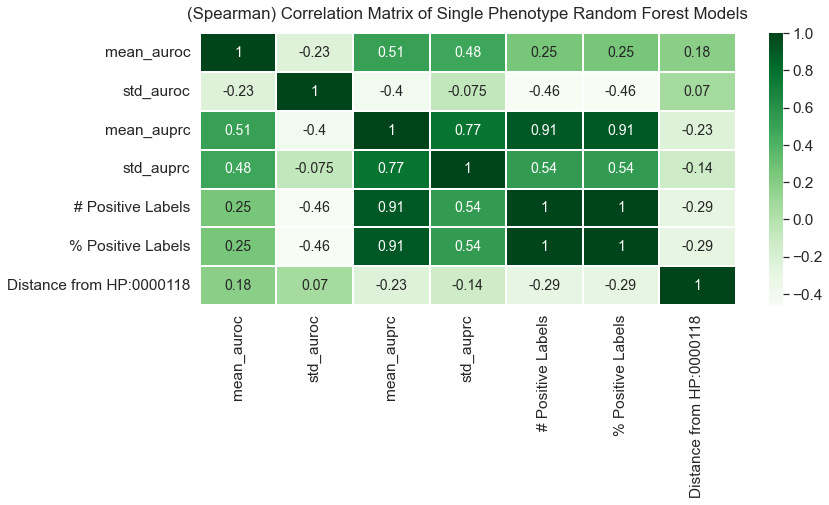

In [22]:
# Build the plot
plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
sns.heatmap(cv_df.corr(method="spearman"), annot=True, annot_kws={"size": 14}, cmap=plt.cm.Greens, linewidths=0.2)
plt.title("(Spearman) Correlation Matrix of Single Phenotype Random Forest Models", y=1.03)
plt.savefig("figures/corr_single_phenotype_measures.png", bbox_inches="tight", dpi=300)
plt.show()

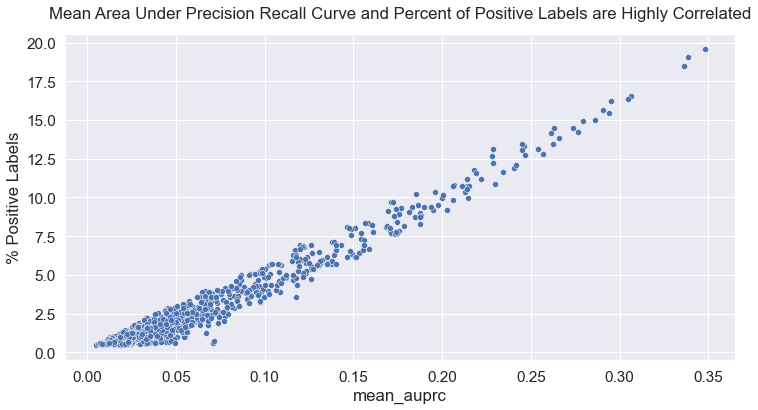

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=cv_df, x="mean_auprc", y="% Positive Labels")
plt.title("Mean Area Under Precision Recall Curve and Percent of Positive Labels are Highly Correlated", y=1.03)
plt.savefig("figures/auprc_vs_positive_labels.png", bbox_inches="tight", dpi=300)
plt.show()

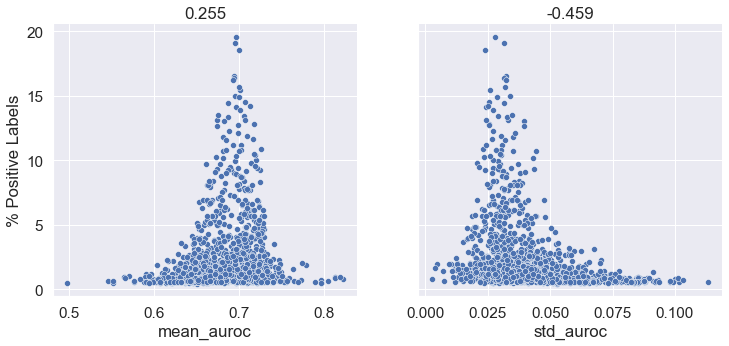

In [24]:
from scipy.stats import spearmanr

fig, ax = plt.subplots(1,2,figsize=(12,5), sharey=True)
sns.scatterplot(data=cv_df, x="mean_auroc", y="% Positive Labels", ax=ax[0])
sns.scatterplot(data=cv_df, x="std_auroc", y="% Positive Labels", ax=ax[1])
sns.despine()

corr = round(spearmanr(cv_df["mean_auroc"], cv_df["% Positive Labels"]).correlation, 3)
ax[0].title.set_text(f"{corr}")
corr = round(spearmanr(cv_df["std_auroc"], cv_df["% Positive Labels"]).correlation, 3)
ax[1].title.set_text(f"{corr}")

plt.savefig("figures/auroc_vs_positive_labels.png", bbox_inches="tight", dpi=300)
plt.show()

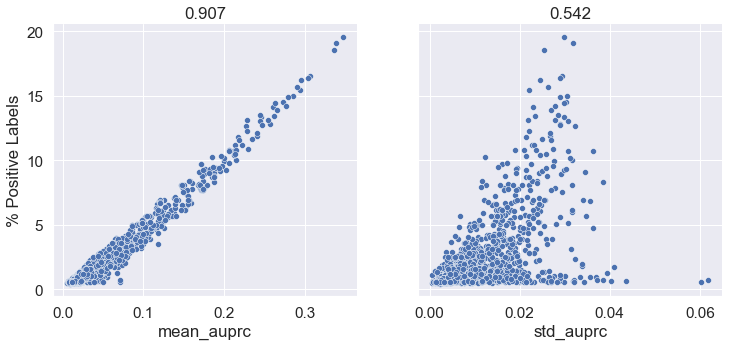

In [25]:
fig, ax = plt.subplots(1,2,figsize=(12,5), sharey=True)
sns.scatterplot(data=cv_df, x="mean_auprc", y="% Positive Labels", ax=ax[0])
sns.scatterplot(data=cv_df, x="std_auprc", y="% Positive Labels", ax=ax[1])
sns.despine()

corr = round(spearmanr(cv_df["mean_auprc"], cv_df["% Positive Labels"]).correlation, 3)
ax[0].title.set_text(f"{corr}")
corr = round(spearmanr(cv_df["std_auprc"], cv_df["% Positive Labels"]).correlation, 3)
ax[1].title.set_text(f"{corr}")

plt.savefig("figures/auprc_vs_positive_labels_2.png", bbox_inches="tight", dpi=300)
plt.show()

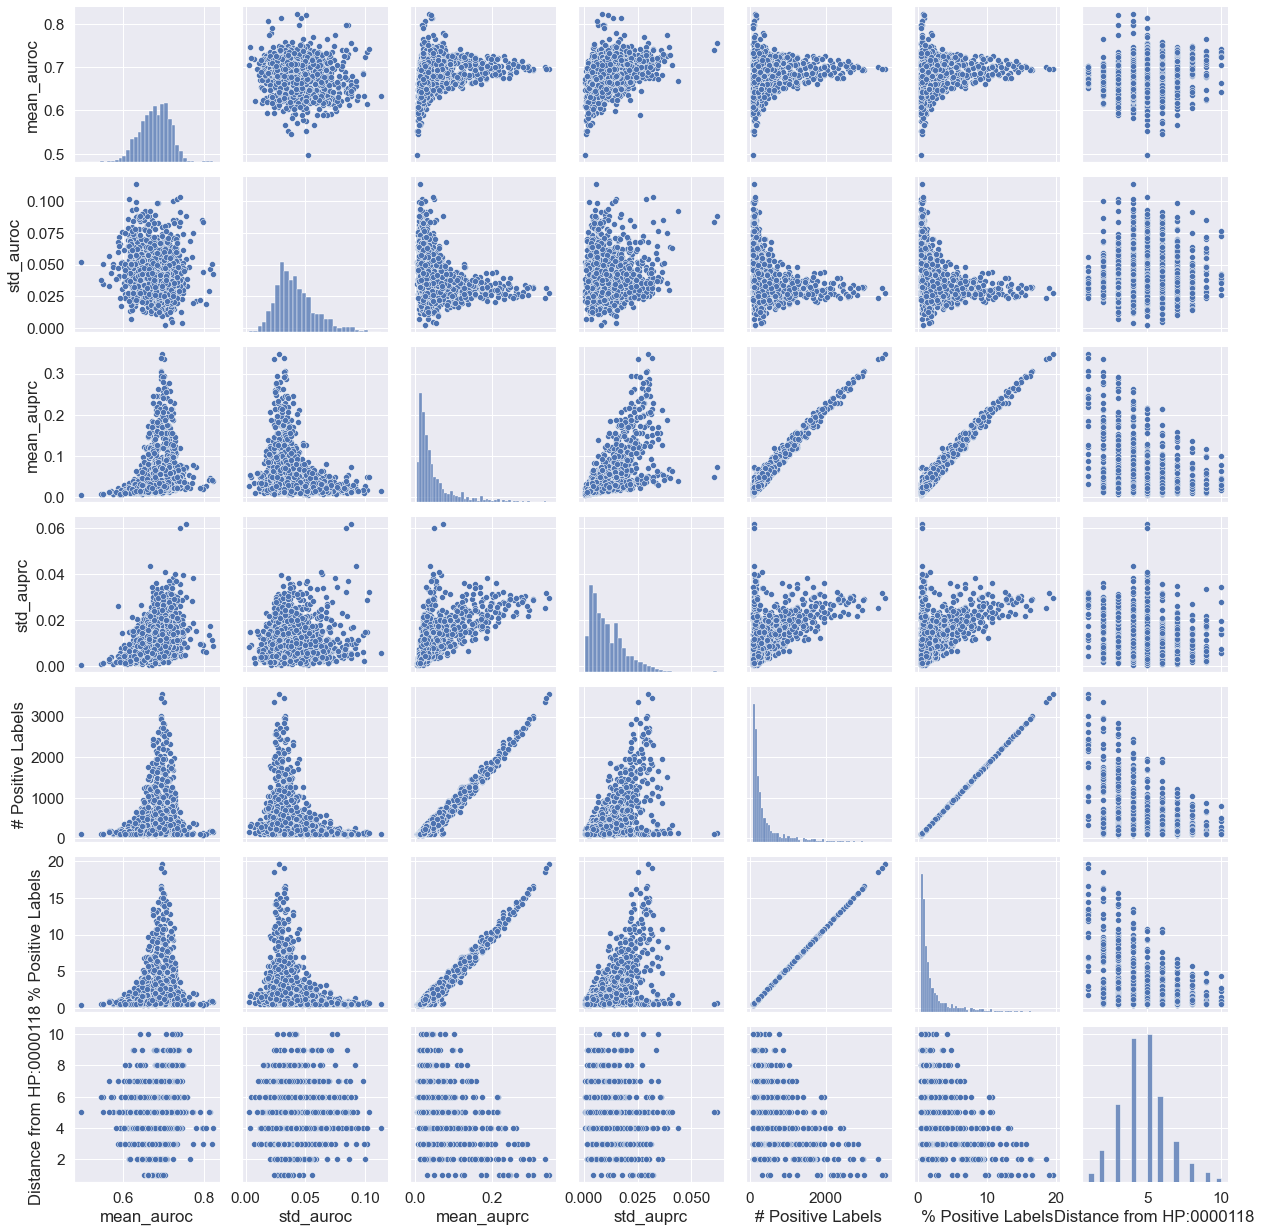

In [26]:
sns.pairplot(cv_df)
plt.savefig("figures/single_phenotype_pairplot.png", bbox_inches="tight", dpi=300)
plt.show()

In [27]:
cv_df = pd.read_csv("./results/single_phenotype_cv_scores.csv", index_col=0)
cv_df

,mean_auroc,std_auroc,mean_auprc,std_auprc,HPO ID,HPO Name,# Positive Labels,% Positive Labels,Distance from HP:0000118
HP:0000002,0.699835,0.031420,0.161048,0.019635,HP:0000002,Abnormality of body height,1413,7.776555,2.0
HP:0000003,0.627032,0.035225,0.011078,0.002610,HP:0000003,Multicystic kidney dysplasia,113,0.621904,7.0
HP:0000008,0.642107,0.041322,0.036983,0.006602,HP:0000008,Abnormal morphology of female internal genitalia,400,2.201431,5.0
HP:0000009,0.688800,0.024942,0.050255,0.009343,HP:0000009,Functional abnormality of the bladder,422,2.322510,5.0
HP:0000010,0.598965,0.051693,0.017696,0.014473,HP:0000010,Recurrent urinary tract infections,139,0.764997,4.0
...,...,...,...,...,...,...,...,...,...
HP:0410263,0.678605,0.032383,0.012260,0.001345,HP:0410263,Brain imaging abnormality,107,0.588883,3.0
HP:0410280,0.676159,0.037642,0.107959,0.024117,HP:0410280,Pediatric onset,941,5.178866,NaN
HP:0500015,0.665838,0.076018,0.023272,0.011732,HP:0500015,Abnormal cardiac test,117,0.643919,2.0
HP:3000050,0.671334,0.043200,0.022314,0.005682,HP:3000050,Abnormal odontoid tissue morphology,210,1.155751,3.0


## Playing with HPO

In [46]:
import networkx as nx

OBO = nx.gpickle.read_gpickle("data/hp.220616.obo.gpickle")

In [68]:
successors = [x for x in OBO.predecessors("HP:0000118")]
# successors = [OBO.nodes()[x]["name"] for x in successors]